In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os
import random

/Users/crhanlon/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


## Data Ingestion

### Data Reading

In [2]:
total_df = pd.read_csv(open('../data/train.csv', 'r'))

/Users/crhanlon/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (47) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Transformation

We need to transform the data in multiple ways
1. Change the team name abbreviations that are inconsistent
2. Change the home/away, team name abbreviations to be same.  Should have
    1. Home/Away
    2. Player's Team
    3. Opposing team
    4. Side of field it's on (left/right)
3. Standardize everything to go left to right.  If originally going R -> L, need to change
    1. X
    2. Direction
    3. Orientation
    4. YardLine

In [15]:
# Change the FieldPosition/PossessionTeam columns to match the VisitorTeamAbbr, HomeTeamAbbr
TEAM_TRANSFORMATION = {
    'ARZ': 'ARI',
    'BLT': 'BAL',
    'CLV': 'CLE',
    'HST': 'HOU'
}

def new_team(team):
    if team in TEAM_TRANSFORMATION:
        return TEAM_TRANSFORMATION[team]
    return team

new_fp = total_df['FieldPosition'].map(new_team)
total_df['FieldPosition'] = new_fp
new_pt = total_df['PossessionTeam'].map(new_team)
total_df['PossessionTeam'] = new_pt

## Play Level

### Transformation

In [16]:
def _augment_matrix(play_df):
    """
    inputs:
        play_df (pandas DataFrame): DataFrame containing all play information
    outputs:
        augmented_df (pandas DataFrame): DataFrame containing augmented information
    """
    augmented_df = play_df.copy()
    
    # Identify the rusher
    runner_id = play_df.iloc[0]['NflIdRusher']
    runner_row = play_df[play_df['NflId'] == runner_id]
    if runner_row.shape[0] != 1:
        raise Exception('Incorrect runner matching')
    runner_row = runner_row.iloc[0]
    
    # Identify the team that has possession
    possession_team_ha = runner_row['Team']
    
    # Determine whether the ball is on the home/road team's side of the field
    home_team = runner_row['HomeTeamAbbr']
    field_pos_home = 'away'
    if augmented_df.iloc[0]['FieldPosition'] == home_team:
        field_pos_home = 'home'
    
    # Flip if necessary
    if runner_row['PlayDirection'] == 'left':
        augmented_df['standardX'] = play_df['X'] - 2*(play_df['X'] - 60)
        augmented_df['standardOrientation'] = (play_df['Orientation'] + 180) % 360
        augmented_df['standardDir'] = (play_df['Dir'] + 180) % 360
    else:
        augmented_df['standardX'] = play_df['X']
        augmented_df['standardOrientation'] = play_df['Orientation']
        augmented_df['standardDir'] = play_df['Dir']
    # Modify the yard line as necessary
    # It is before the 50 if the runner is home and the FieldPosition is home or if the runner is away and FieldPosition is away
    # It is after the 50 if the runner is home and the FieldPosition is away or if the runner is away and FieldPosition is home
    if field_pos_home == possession_team_ha:
        augmented_df['standardYardLine'] = play_df['YardLine'] + 10
    else:
        augmented_df['standardYardLine'] = 110 - play_df['YardLine']
    
    # End result of play
    augmented_df['standardEndYardLine'] = augmented_df['standardYardLine'] + augmented_df['Yards']
    
    # Indicates if the player is on offense
    augmented_df['isOffense'] = augmented_df['Team'] == possession_team_ha
    # Indicates the side of the field relative to home/road team
    augmented_df['fieldPositionHome'] = field_pos_home
    # Indicates if the player is the rusher
    augmented_df['isRusher'] = augmented_df['NflId'] == runner_id
    return augmented_df

### Plotting

In [17]:
def plot_augmented_df(augmented_df, zoom=False):
    """
    inputs:
        augmented_df(pandas DataFrame): play's augmented dataframe
    outputs:
        figure (pyplot figure): figure of play
    """
    # Subset dataframe
    non_rushing_df = augmented_df[~augmented_df['isRusher']]
    rushing_df = augmented_df[augmented_df['isRusher']]
    offense_df = non_rushing_df[non_rushing_df['isOffense']]
    defense_df = non_rushing_df[~non_rushing_df['isOffense']]
    
    # Identify player coordinates
    off_x = offense_df['standardX']
    off_y = offense_df['Y']
    rush_x = rushing_df['standardX']
    rush_y = rushing_df['Y']
    def_x = defense_df['standardX']
    def_y = defense_df['Y']
    
    # Line of scrimmage
    los = rushing_df.iloc[0]['standardYardLine']
    
    # End yard line
    eyl = rushing_df.iloc[0]['standardEndYardLine']
    
    # Initialize figure
    fig = plt.figure(1, figsize=[12, 5])
    
    # Plot yard lines
    plt.plot([0, 120], [0, 0], c='k')
    plt.plot([0, 120], [53.3, 53.3], c='k')
    plt.plot([0, 0], [0, 53.3], c='k')
    plt.plot([10, 10], [0, 53.3], c='k')
    plt.plot([110, 110], [0, 53.3], c='k')
    plt.plot([120, 120], [0, 53.3], c='k')
    for i in range(15, 106, 5):
        if i == 60:
            plt.plot([i, i], [0, 53.3], c='k', ls='-')
        else:
            plt.plot([i, i], [0, 53.3], c='k', ls='--')
    
    # Plot LOS
    plt.plot([los, los], [0, 53.3], c='m', ls='--')
    # Plot end yard
    plt.plot([eyl, eyl], [0, 53.3], c='c', ls='--')
    
    # Plot players
    plt.scatter(off_x, off_y, c='b')
    plt.scatter(rush_x, rush_y, c='g')
    plt.scatter(def_x, def_y, c='r')
    plt.show()

20170924061208


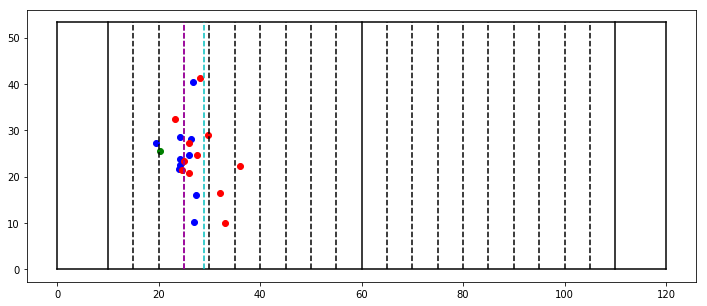

20181028103835


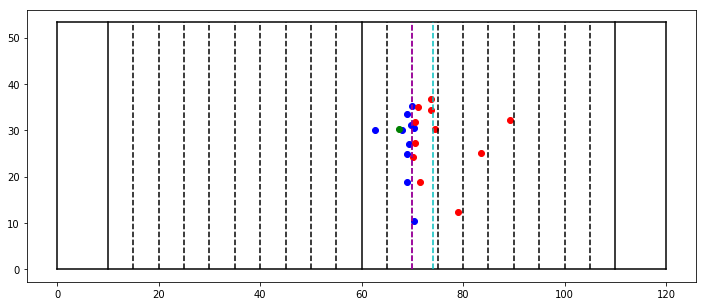

20171119063206


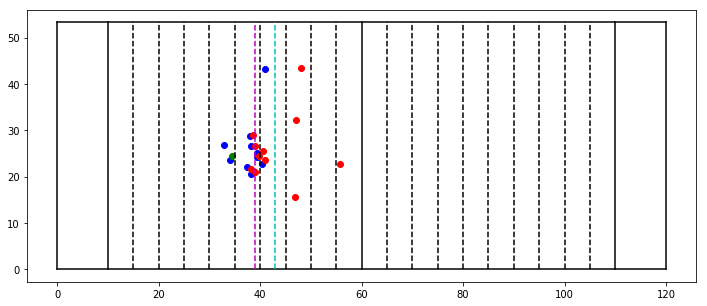

20171105071802


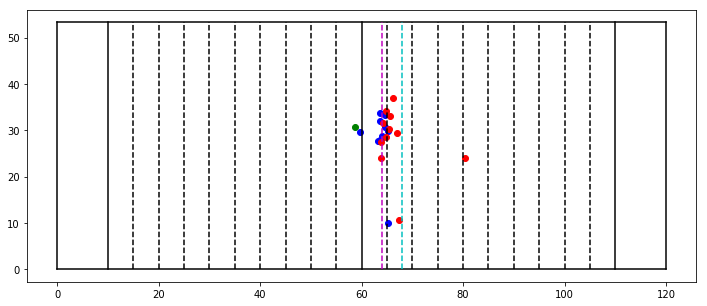

20171231124111


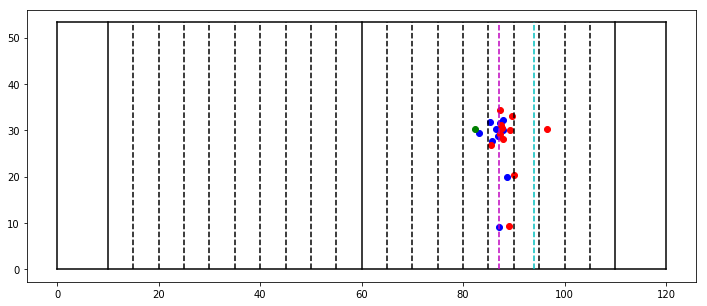

20181021110416


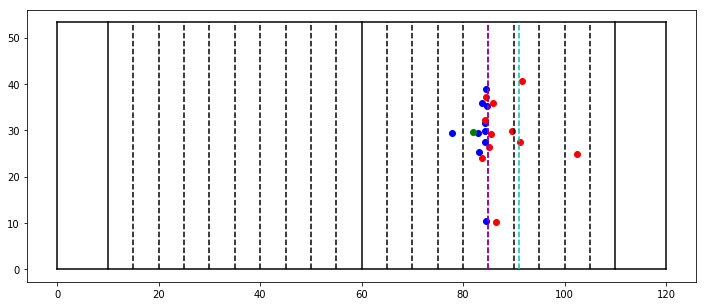

20171015072214


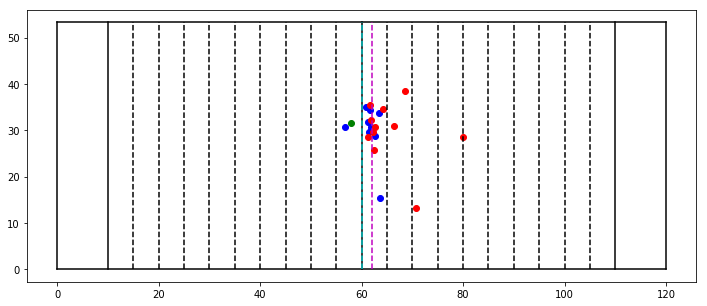

20181230102262


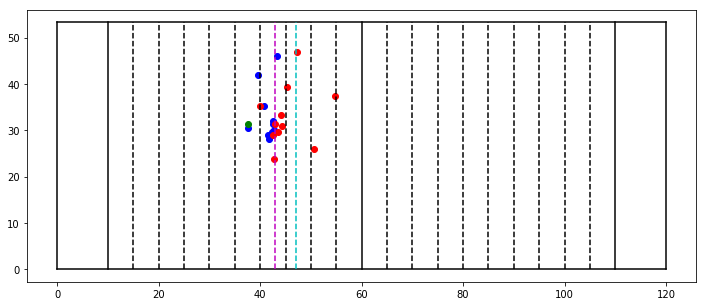

20171224023215


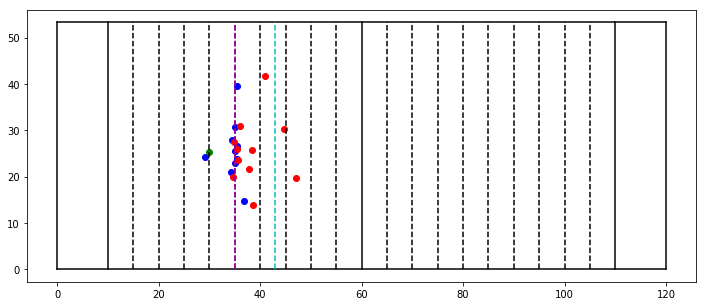

20171217042366


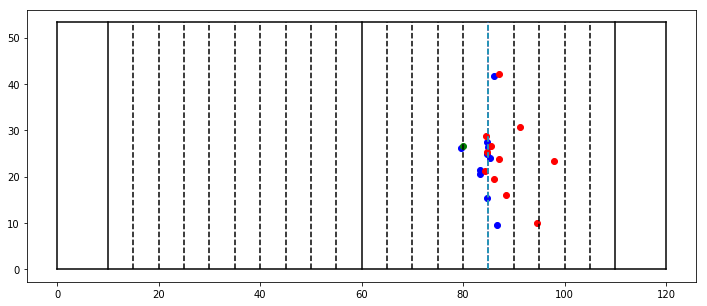

20181028041810


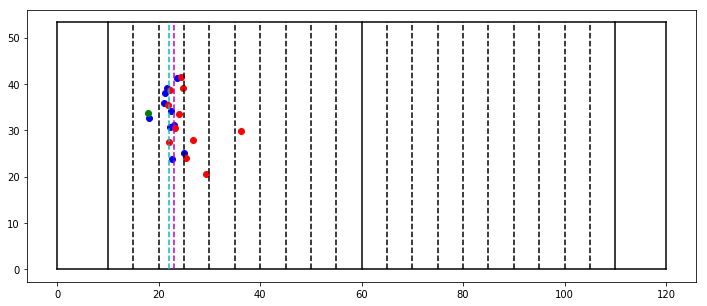

20181007000281


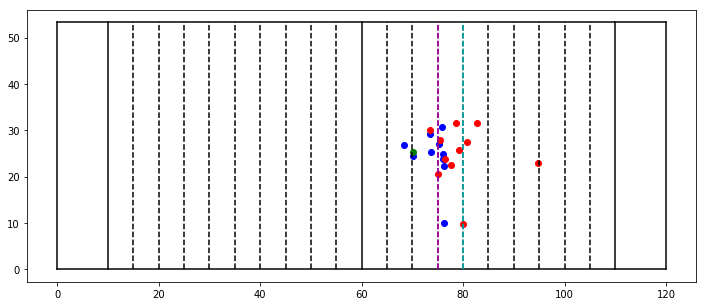

20171119053102


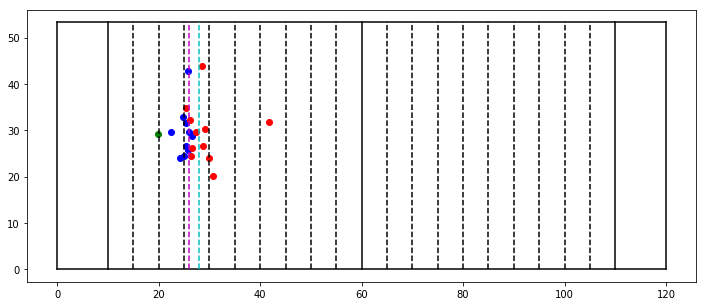

20180916131453


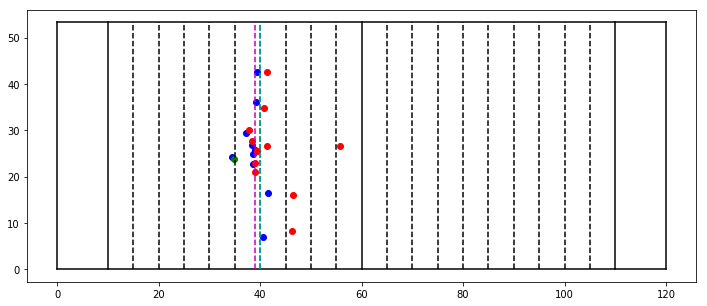

20181125083014


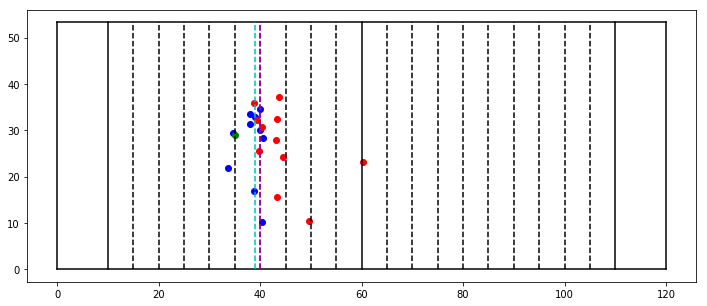

20181014044181


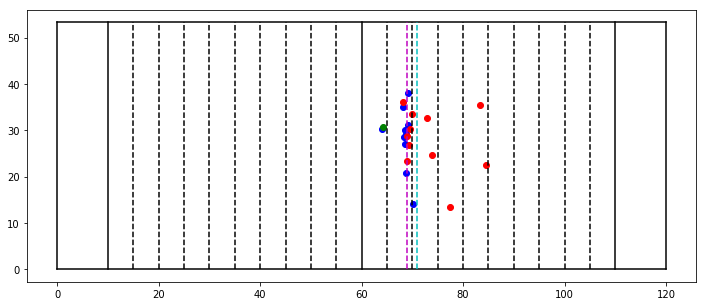

20180923121477


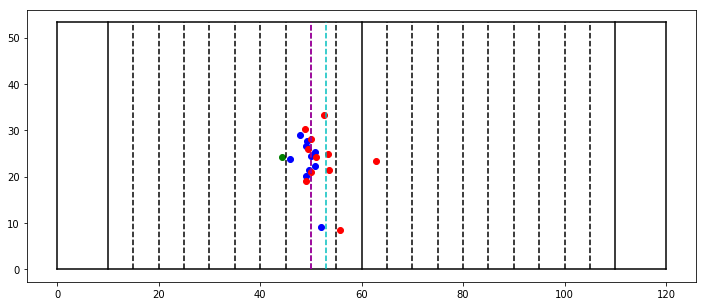

20181104073456


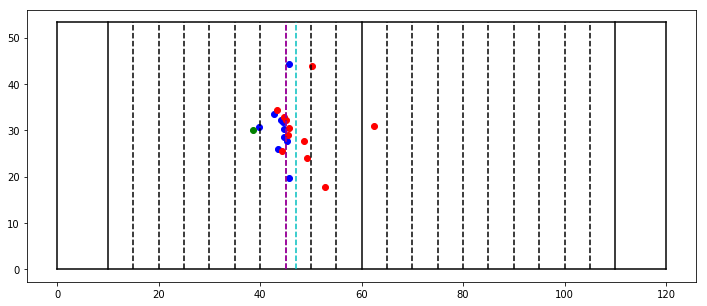

20180923051161


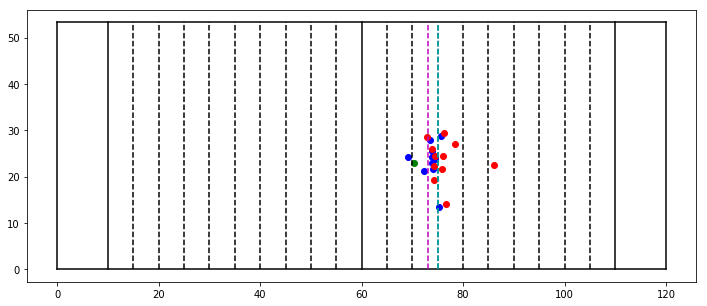

20181104022284


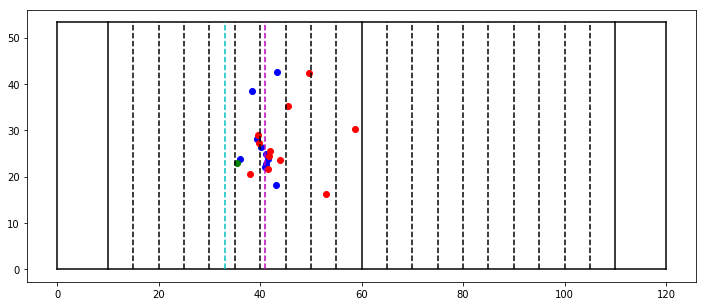

20171112112737


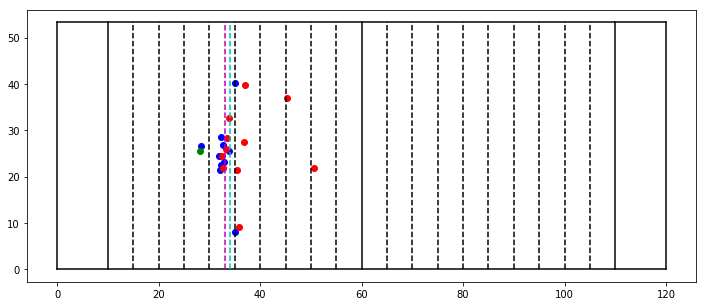

20181209123324


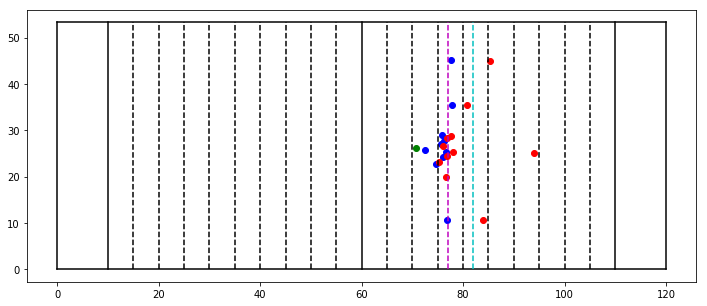

20170917112232


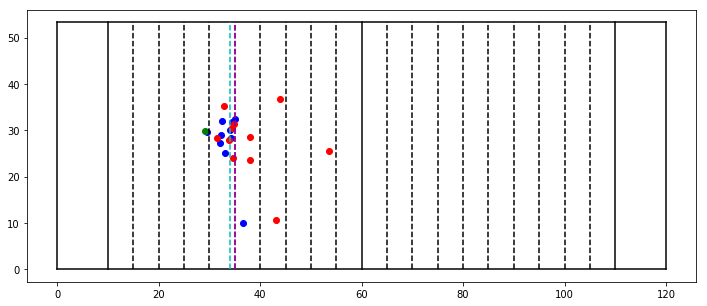

20180930042556


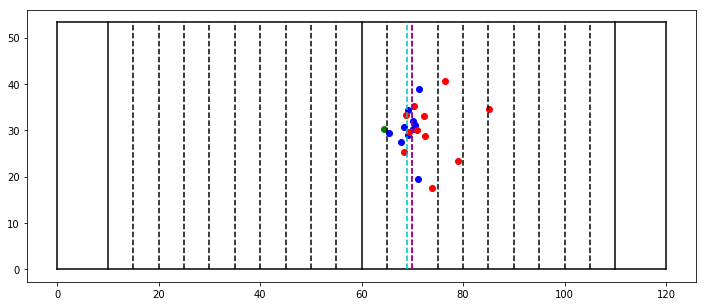

20171112003450


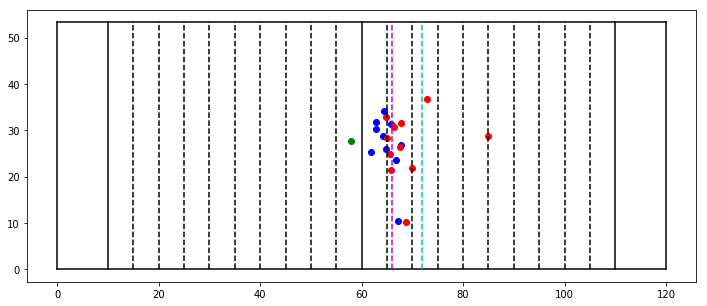

In [18]:
play_id_list = np.random.choice(total_df['PlayId'].unique(), 25)
for p_id in play_id_list:
    play_df = total_df[total_df['PlayId'] == p_id]
    augmented_df = _augment_matrix(play_df)
    print(p_id)
    plot_augmented_df(augmented_df)